<a href="https://colab.research.google.com/github/SeanBarnier/HAFS_Air-Sea/blob/main/HAFSA_Atmosphere.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Retrieves HAFS-A data from AWS along a storm's track using files generated by getStormTrack.ipynb.

Set up environment

In [ ]:
!pip install cfgrib
!pip install cartopy
!pip install tropycal

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.7/11.7 MB 96.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.1/10.1 MB 80.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for tropycal: filename=tropycal-1.3-py3-none-any.whl size=242631 sha256=9f363f6b97849b0ae6046c65adb426ef14eeb9345dd136892dd790151372fb2e
  Stored in directory: /root/.cache/pip/wheels/45/b3/db/78c9a2a51e8db2d962647d8dd0bb4e1ed5e1005254353de4af
Successfully built tropycal


In [ ]:
from tropycal import tracks, rain
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime as dt
import cfgrib
import numpy as np

In [40]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


User parameters

In [41]:
name = "Milton"
tcNum = "14"
filepath = f"/content/drive/MyDrive/ColabNotebooks/{name}"
trackType = "major"

Open TC Data

In [42]:
tc = pd.read_csv(filepath + "/hurdat2_" + name + "_" + trackType + ".csv")

In [43]:
tc

,Unnamed: 0,index,time,extra_obs,special,type,lat,lon,vmax,mslp,wmo_basin
0,0,11,2024-10-07 12:00:00,0,NaN,HU,21.8,-92.2,120,943,north_atlantic
1,1,12,2024-10-07 18:00:00,0,NaN,HU,21.7,-91.3,150,908,north_atlantic
2,2,13,2024-10-07 20:00:00,1,I,HU,21.8,-90.9,155,895,north_atlantic
3,3,14,2024-10-08 00:00:00,0,NaN,HU,21.8,-90.4,145,902,north_atlantic
4,4,15,2024-10-08 06:00:00,0,NaN,HU,21.9,-89.5,125,925,north_atlantic
5,5,16,2024-10-08 12:00:00,0,NaN,HU,22.5,-88.8,125,929,north_atlantic
6,6,17,2024-10-08 18:00:00,0,NaN,HU,22.5,-88.0,140,916,north_atlantic
7,7,18,2024-10-08 22:05:00,1,R,HU,22.8,-87.2,145,902,north_atlantic
8,8,19,2024-10-09 00:00:00,0,NaN,HU,23.0,-86.9,140,908,north_atlantic
9,9,20,2024-10-09 02:05:00,1,R,HU,23.3,-86.6,135,916,north_atlantic


Retrieve HAFS-A Atmospheric Data

In [47]:
dateFormat = "%Y-%m-%d %H:%M:%S"
runFormat = "%Y%m%d%H"

start = tc.time[0]
startDate, startTime = start.split(" ")
startYear, startMonth, startDay = startDate.split("-")
startHour, startMinute, startSecond = startTime.split(":")

end = tc.time[len(tc)-1]
endDT = dt.strptime(end, dateFormat)
endDate, endTime = end.split(" ")
endYear, endMonth, endDay = endDate.split("-")
endHour, endMinute, endSecond = endTime.split(":")

Determine times needed

In [45]:
#Sample URL: https://noaa-nws-hafs-pds.s3.amazonaws.com/hfsa/20241007/12/13l.2024100712.hfsa.mom6.f000.nc
#            https://noaa-nws-hafs-pds.s3.amazonaws.com/hfsa/20241007/12/13l.2024100712.hfsa.parent.atm.

bucket = "https://noaa-nws-hafs-pds.s3.amazonaws.com/hfsa/"

fcastTimes = {} #Key: initiation, item: Forecast Hour

for row in tc.iloc:
  fcastTimes[row.time] = []
  rowTime = dt.strptime(row.time, dateFormat)
  if rowTime.hour % 6 != 0 or rowTime.minute != 0: continue #Skip any lines that don't have a HAFS forecast at the same time

  for fhour in range(0, 127, 3):
    valid = rowTime + pd.Timedelta(hours=fhour)
    if valid <= endDT:
      fcastTimes[row.time].append(fhour)

Get all files needed

In [58]:
parentFiles = []
stormFiles = []

stormMSLP = {} #Stores pressure along TC track for all forecast hours
parentMSLP = {}

for init, fhourList in fcastTimes.items():
  for fhour in fhourList:

    fhour = str(fhour)
    while len(fhour) < 3: fhour = "0" + fhour

    initDate, initTime = init.split(" ")
    initYear, initMonth, initDay = initDate.split("-")
    initHour, initMinute, initSecond = initTime.split(":")

    parentURL = bucket + initDate.replace("-", "") + "/" + initHour + "/" + tcNum + "l." + initDate.replace("-", "") + initHour + ".hfsa.parent.atm.f" + fhour + ".grb2"
    stormURL = bucket + initDate.replace("-", "") + "/" + initHour + "/" + tcNum + "l." + initDate.replace("-", "") + initHour + ".hfsa.storm.atm.f" + fhour + ".grb2"

    parentFile = "parent_" + initDate.replace("-", "") + "_" + initHour + "_f" + fhour + ".grb2"
    stormFile = "storm_" + initDate.replace("-", "") + "_" + initHour + "_f" + fhour + ".grb2"
    parentFiles.append(parentFile)
    stormFiles.append(stormFile)

    !wget -O {parentFile} {parentURL}
    !wget -O {stormFile} {stormURL}

    _, dateStr, hour, fhourStr = parentFile.split("_") #Same for both parent and storm of files
    runStr = dateStr + hour
    fhour = int(fhourStr.replace("f", "").replace(".grb2", ""))
    validDT = dt.strptime(runStr, runFormat) + pd.Timedelta(hours=fhour)

    if runStr not in stormMSLP.keys(): stormMSLP[runStr] = {}
    if runStr not in parentMSLP.keys(): parentMSLP[runStr] = {}

    parentData = xr.open_dataset(parentFile, engine="cfgrib", decode_timedelta=True, filter_by_keys={'stepType': 'instant', 'typeOfLevel': 'meanSea'})
    parentMSLP[runStr][validDT] = np.min(parentData.prmsl.data[np.isnan(parentData.prmsl.data)==False]) / 100 #Convert from Pa to hPa

    stormData = xr.open_dataset(stormFile, engine="cfgrib", decode_timedelta=True, filter_by_keys={'stepType': 'instant', 'typeOfLevel': 'meanSea'})
    stormMSLP[runStr][validDT] = np.min(stormData.prmsl.data[np.isnan(stormData.prmsl.data)==False]) / 100

    !rm {stormFile}
    !rm {parentFile}

--2025-06-11 20:24:35--  https://noaa-nws-hafs-pds.s3.amazonaws.com/hfsa/20241007/12/14l.2024100712.hfsa.parent.atm.f000.grb2
Resolving noaa-nws-hafs-pds.s3.amazonaws.com (noaa-nws-hafs-pds.s3.amazonaws.com)... 52.217.206.89, 52.216.8.19, 16.15.193.117, ...
Connecting to noaa-nws-hafs-pds.s3.amazonaws.com (noaa-nws-hafs-pds.s3.amazonaws.com)|52.217.206.89|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 837674250 (799M) [application/octet-stream]
Saving to: ‘parent_20241007_12_f000.grb2’

parent_20241007_12_ 100%[===================>] 798.87M  62.7MB/s    in 12s     

2025-06-11 20:24:46 (68.7 MB/s) - ‘parent_20241007_12_f000.grb2’ saved [837674250/837674250]

--2025-06-11 20:24:46--  https://noaa-nws-hafs-pds.s3.amazonaws.com/hfsa/20241007/12/14l.2024100712.hfsa.storm.atm.f000.grb2
Resolving noaa-nws-hafs-pds.s3.amazonaws.com (noaa-nws-hafs-pds.s3.amazonaws.com)... 52.217.128.57, 52.216.216.113, 54.231.236.233, ...
Connecting to noaa-nws-hafs-pds.s3.amazonaws.

In [ ]:
#Unused code to locate MSLP along storm track geographically

#print("\n", row.lat)
  #print(float(stormData.sel(latitude=row.lat, method="nearest").sel(longitude=row.lon, method="nearest").latitude.data))
  #print(float(parentData.sel(latitude=row.lat, method="nearest").sel(longitude=row.lon, method="nearest").latitude.data))

  #print("\n", row.lon+360)
  #print(float(stormData.sel(latitude=row.lat, method="nearest").sel(longitude=row.lon+360, method="nearest").longitude.data))
  #print(float(parentData.sel(latitude=row.lat, method="nearest").sel(longitude=row.lon+360, method="nearest").longitude.data))

  #stormMSLP[row.time] = float(stormData.sel(latitude=row.lat, method="nearest").sel(longitude=row.lon+360, method="nearest").prmsl.data)/100
  #parentMSLP[row.time] = float(parentData.sel(latitude=row.lat, method="nearest").sel(longitude=row.lon+360, method="nearest").prmsl.data)/100


In [ ]:
parentMSLP

In [ ]:
stormMSLP

Create MSLP Figure

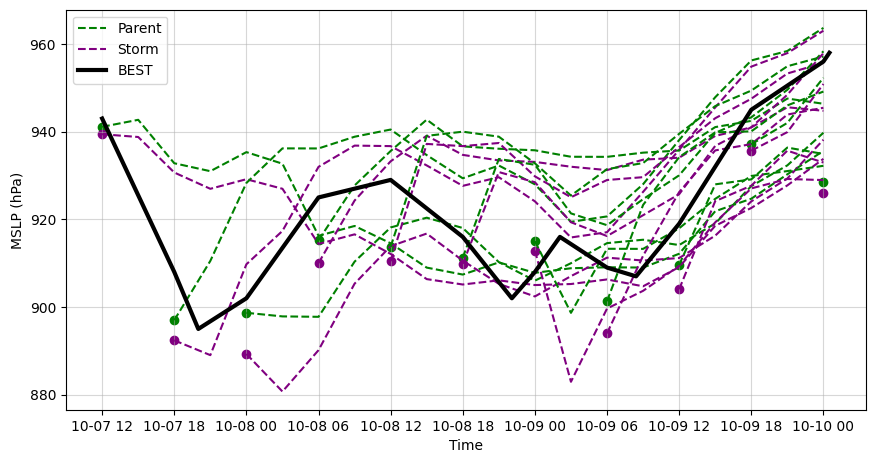

In [70]:
btDates = [dt.strptime(datetime, dateFormat) for datetime in tc.time]
runDates = [dt.strptime(run, runFormat) for run in parentMSLP.keys()]
parentStartMSLPs = [list(parentMSLP[key].values())[0] for key in parentMSLP.keys()]
stormStartMSLPs = [list(stormMSLP[key].values())[0] for key in stormMSLP.keys()]

mslpFig = plt.figure(figsize=(10, 5))
mslpAx = mslpFig.add_axes([0.1,0.1,0.8,0.8])

for run in parentMSLP.keys():
  if run == list(parentMSLP.keys())[0]:
    mslpAx.plot(parentMSLP[run].keys(), parentMSLP[run].values(), label="Parent", linestyle="--", color="green")
    mslpAx.plot(stormMSLP[run].keys(), stormMSLP[run].values(), label="Storm", linestyle="--", color="purple")
  else:
    mslpAx.plot(parentMSLP[run].keys(), parentMSLP[run].values(), linestyle="--", color="green")
    mslpAx.plot(stormMSLP[run].keys(), stormMSLP[run].values(), linestyle="--", color="purple")

#Add points to indicate the start of a run
mslpAx.scatter(runDates, parentStartMSLPs, color="green")
mslpAx.scatter(runDates, stormStartMSLPs, color="purple")

mslpAx.plot(btDates, tc.mslp, label="BEST", color="black", linewidth=3)

mslpAx.set_xlabel("Time")
mslpAx.set_ylabel("MSLP (hPa)")
mslpAx.grid(alpha=0.5)
mslpAx.legend()

mslpFig.savefig(filepath + "/mslp_allRuns.png")

# Model track error
Quantify and maybe plot. Be careful if there are multiple min MSLP pixels.